# 답변에 이미지도 함께 표시하는 예제

In [ ]:
# 필요한 라이브러리 설치

!pip install langchain langchain_aws faiss-cpu pymupdf4llm pillow boto3 -q -U

In [1]:
# 필요한 모듈 임포트

import os
import shutil
import time
import base64

import boto3

import pymupdf4llm # pdf의 텍스트 및 이미지를 추출할 parser

from langchain_aws import ChatBedrock
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import BedrockEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
import pathlib
import re
from IPython.display import display, Image, Markdown

In [2]:
# PDF 파싱 결과(md 및 이미지)를 저장할 ./temp 디렉토리 설정

def manage_temp_directory():
    temp_dir = "./temp"

    # 디렉토리가 존재하는지 확인
    if os.path.exists(temp_dir):
        print(f"{temp_dir} 디렉토리가 이미 존재합니다.")

        # 디렉토리 내의 모든 파일 삭제
        for filename in os.listdir(temp_dir):
            file_path = os.path.join(temp_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")

        print(f"{temp_dir} 디렉토리 내의 모든 파일이 삭제되었습니다.")
    else:
        # 디렉토리가 없으면 생성
        os.makedirs(temp_dir)
        print(f"{temp_dir} 디렉토리가 생성되었습니다.")

# 함수 실행
manage_temp_directory()

./temp 디렉토리가 이미 존재합니다.
./temp 디렉토리 내의 모든 파일이 삭제되었습니다.


In [3]:
%%time

# PDF 파일 경로
pdf_path = "./rag_data/world_steel_dynamics_2406.pdf"

# 임시 디렉토리 생성
temp_dir = pathlib.Path("./temp")
temp_dir.mkdir(exist_ok=True)

# PDF를 마크다운으로 변환 (텍스트와 이미지 포함)
md_text = pymupdf4llm.to_markdown(pdf_path, write_images=True)

# 결과를 파일로 저장
output_path = temp_dir / "output.md"
output_path.write_text(md_text, encoding="utf-8")

# 이미지 파일들을 temp 디렉토리로 이동
pdf_name = pathlib.Path(pdf_path).stem
for file in pathlib.Path().glob(f"{pdf_name}*.png"):
    shutil.move(str(file), str(temp_dir / file.name))

print(f"마크다운 파일이 {output_path.absolute()}에 저장되었습니다.")
print(f"이미지 파일들이 {temp_dir.absolute()} 디렉토리로 이동되었습니다.")

마크다운 파일이 /home/sagemaker-user/sct_traiding_poc/temp/output.md에 저장되었습니다.
이미지 파일들이 /home/sagemaker-user/sct_traiding_poc/temp 디렉토리로 이동되었습니다.
CPU times: user 38.1 s, sys: 175 ms, total: 38.3 s
Wall time: 48.5 s


In [4]:
# 문서를 벡터라이즈

# 마크다운 파일 로드
loader = TextLoader("./temp/output.md", encoding="utf-8")
documents = loader.load()

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
)
splits = text_splitter.split_documents(documents)

In [5]:
%%time

# 임베딩 생성 및 벡터 스토어 구축
embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1")
vectorstore = FAISS.from_documents(splits, embeddings)

CPU times: user 761 ms, sys: 69.3 ms, total: 831 ms
Wall time: 30.4 s


In [6]:
# ChatBedrock 초기화 (Claude 3 Sonnet 모델 사용)
llm = ChatBedrock(
    #model_id="anthropic.claude-3-5-sonnet-20240620-v1:0" # Claude 3.5 Sonnet
    model_id="anthropic.claude-3-sonnet-20240229-v1:0" # Claude 3 Sonnet
)

# RetrievalQA 체인 설정
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(),
    return_source_documents=True,
)

In [7]:
# 이미지 파일 경로 추출 함수
def extract_image_paths(text):
    return re.findall(r'!\[.*?\]\((.*?\.png)\)', text)

# 질의 응답 함수
def ask_question(question):
    result = qa_chain({"query": question})
    answer = result["result"]
    source_docs = result["source_documents"]

    # 관련 이미지 파일 경로 추출
    image_paths = []
    for doc in source_docs:
        image_paths.extend(extract_image_paths(doc.page_content))

    return answer, list(set(image_paths))  # 중복 제거

# 질문 및 답변 출력 함수
def print_qa_with_images(question):
    answer, image_paths = ask_question(question)

    print(f"질문: {question}")
    print(f"답변: {answer}")

    if image_paths:
        print("\n관련 이미지:")
        for path in image_paths:
            full_path = pathlib.Path("./temp") / path
            if full_path.exists():
                display(Image(filename=str(full_path)))
            else:
                print(f"이미지 파일을 찾을 수 없습니다: {path}")
    else:
        print("\n관련 이미지가 없습니다.")


질문: 
China Coke Export

답변: According to the data provided, China's coke exports have seen a significant increase in recent years:

- In April 2024, China's total coke exports reached 929,002 metric tonnes, up 29.19% year-over-year.

- The year-to-date (January-April 2024) coke exports from China were 3,334,666 metric tonnes, up 24.23% compared to the same period in 2023.

- Some major destinations for China's coke exports in April 2024 were:
1) Indonesia (180,941 tonnes, up 96.9% year-over-year)
2) India (116,978 tonnes, down 28.98%)
3) Malaysia (56,525 tonnes, down 58.79%) 
4) Japan (79,890 tonnes, up 25.61%)
5) Brazil (110,112 tonnes)

- Exports to countries like Japan, Vietnam, and Malaysia saw significant year-over-year increases in the January-April 2024 period.

The surge in low-priced coke exports from China (and Indonesia) is cited as a key reason why coking coal prices may be relatively capped this year compared to previous years when prices surged higher. These coke exports 

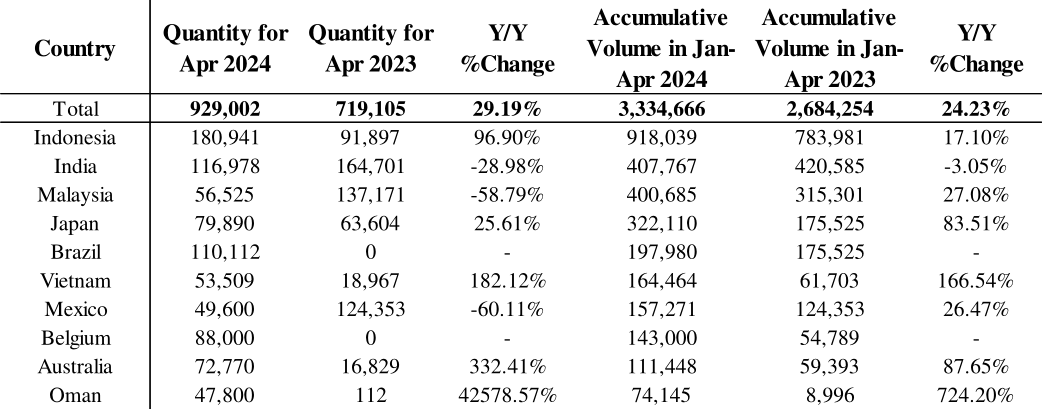



질문: 문서에 포함된 이미지들에 대해 설명해주세요.
답변: 이 문서에는 총 2개의 이미지가 포함되어 있습니다.

첫 번째 이미지는 World Steel Dynamics의 로고로 보입니다. 

두 번째 이미지는 세계 지도를 배경으로 하고 있으며, 지역별로 색상이 구분되어 있습니다. 이 이미지는 World Steel Dynamics의 Plantfacts Capacity 데이터베이스의 주요 기능들을 나열하고 있습니다. 분기별 업데이트, 36가지 제철 설비 유형, 110개국 포함, 12개 지역 그룹, 12,000개 이상의 시설, 엑셀 다운로드 기능 등이 열거되어 있습니다.

관련 이미지:


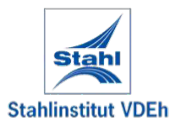

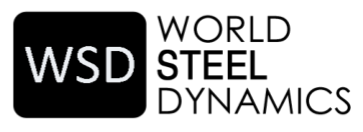

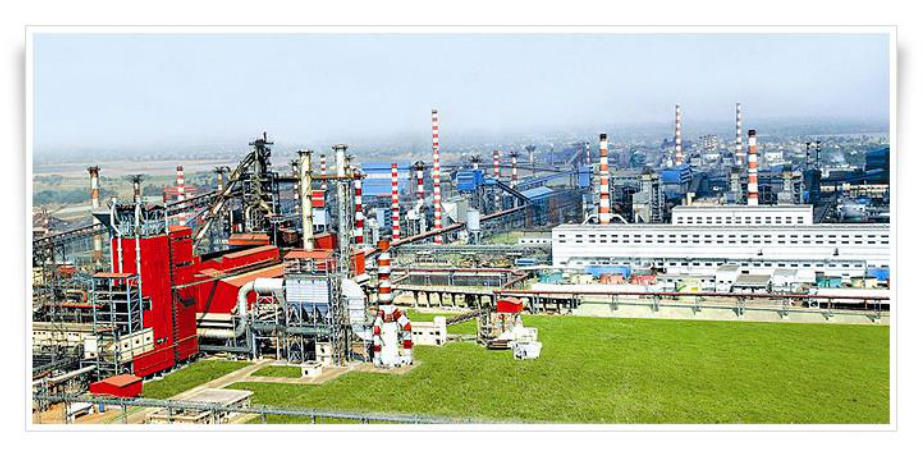

CPU times: user 57.1 ms, sys: 65 μs, total: 57.2 ms
Wall time: 15.9 s


In [10]:
%%time

# 사용자 쿼리
query = """
China Coke Export
"""
print_qa_with_images(query)

print("\n" + "="*50 + "\n")

print_qa_with_images("문서에 포함된 이미지들에 대해 설명해주세요.") # 첨부된 이미지에 대한 추가 설명을 요청함
